In [1]:
#Import necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from sklearn.metrics import log_loss,roc_auc_score,recall_score,plot_roc_curve
from sklearn import datasets, metrics

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 

# Data loading and preprocessing

In [2]:
df_main = pd.read_csv('concrete.csv')

In [3]:
print('')
print('Count of rows and columns present in dataset')
print('')
df_main.shape


Count of rows and columns present in dataset



(1030, 9)

In [4]:
df_main.isnull().values.any() # If there are any null values in data set

False

In [5]:
print('')
print('Info about dataset')
print('')
df_main.info()


Info about dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


# Observation

There are 1030 records in the dataset

There are 9 variables that define the dataset
    
    8 independent variables - cement, slag, ash, water, superplastic, coarseagg, fineagg, age
    and 1 dependent variable - strength

All features are either float or integer. Hence, no type conversion is needed.

Age is defined in number of days while all other independent variables are defined in Kilograms

The target variable Strength is defined in MegaPascals, which is the SI unit of pressure

Strength of the mixture is influenced by the quantities of the various components used and the number of days they are allowed to cure


In [6]:
df_main.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


In [7]:
# Check for null values
# df_main.isnull().apply(pd.value_counts)

df_main.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

In [8]:
df_main.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


# Observation
Cement
    
    There is a wide range of values with a minimum of 102 kg/m^3 to a maximum of 540 kg/m^3
    Hence this is left skewed

Slag

    The first 2 quartile values are 0.0 and the maximum value is 359.4
    Hence this is left skewed
    
Ash

    Similar to Ash, the first 2 quartile values are 0.0. The maximum value is 200.1
    This is also left skewed
    

Slag, Ash & Superplastic: There are a number of records with 0 kg/m^3. 
    This could be a valid scenario where these materials were not used in the concrete mixture. 
    There is no need to impute these features with a central value.

Water: There are no records with NULL or 0 value for this feature.

CoarseAgg, FineAgg: There are no records with NULL or 0 value for these features.
    
Age: 
    Average age of the concrete mixture is ~46 days. 
    The lowest period of observation is 1 day and highest is 365 days.
    The interquartile range for age of concrete is 56-7 = 49 days. 

Strength:
    Average strength of concrete is 35.81 MPa
    
    The minimum strength is 2.33 MPa and the maximum is  82.6 MPa

There are no NaN/NULL values in the dataset

There are no features with object datatype in the dataset

    This means all features are non-categorical and have continuous values 
    Hence there is no need for label or one hot encoding to be applied

The dataset needs to be normalized to bring all features to the same scale

# EDA

# Cement

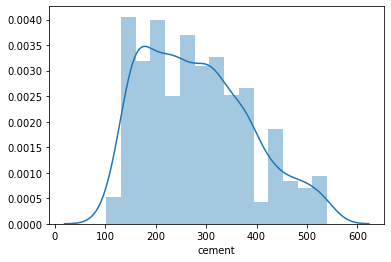

In [9]:
sns.distplot(df_main['cement'])

Cement has a near-normal distribution.

In [10]:
#calculate interquartile range of values in the 'cement' column
q75, q25 = np.percentile(df_main['cement'], [75 ,25])
iqr = q75 - q25

# Inter Quartile Range 
print('First Quartile is: ',q25)
print('Third Quartile is: ',q75)
print('Inter Quartile Range for Cement is: ',iqr)

# Outlier detection
limit_lo = q25-1.5*iqr
limit_uo = q75+1.5*iqr

print('The lower limit for outliers in Cement is: ',limit_lo)
print('The upper limit for outliers in Cement is: ',limit_uo)


First Quartile is:  192.375
Third Quartile is:  350.0
Inter Quartile Range for Cement is:  157.625
The lower limit for outliers in Cement is:  -44.0625
The upper limit for outliers in Cement is:  586.4375


In [11]:
# Identifying outlier values in dataset
cem_uo = df_main[df_main['cement']>limit_uo]['cement'].count()
cem_lo = df_main[df_main['cement']<limit_lo]['cement'].count()

print('Number of upper outliers in the dataset for cement = ',cem_uo)
print('Number of lower outliers in the dataset for cement = ',cem_lo)

Number of upper outliers in the dataset for cement =  0
Number of lower outliers in the dataset for cement =  0


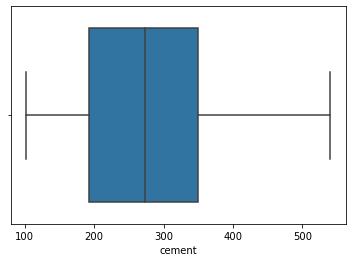

In [12]:
sns.boxplot(x="cement", data=df_main)

# Observation - Cement

There are no outliers in the dataset for the variable cement

Correlation

Observation

Cement has a positive correlation with Strength


# Slag

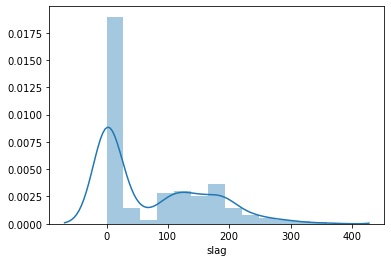

In [13]:
sns.distplot(df_main['slag'])

Slag is right skewed.

In [14]:
#calculate interquartile range of values in the 'slag' column
q75, q25 = np.percentile(df_main['slag'], [75 ,25])
iqr = q75 - q25

# Inter Quartile Range 
print('First Quartile is: ',q25)
print('Third Quartile is: ',q75)
print('Inter Quartile Range for slag is: ',iqr)

# Outlier detection
limit_lo = q25-1.5*iqr
limit_uo = q75+1.5*iqr

print('The lower limit for outliers in slag is: ',limit_lo)
print('The upper limit for outliers in slag is: ',limit_uo)

# Identifying outlier values in dataset
slag_uo = df_main[df_main['slag']>limit_uo]['slag'].count()
slag_lo = df_main[df_main['slag']<limit_lo]['slag'].count()

print('Number of upper outliers in the dataset for slag = ',slag_uo)
print('Number of lower outliers in the dataset for slag = ',slag_lo)

First Quartile is:  0.0
Third Quartile is:  142.95
Inter Quartile Range for slag is:  142.95
The lower limit for outliers in slag is:  -214.42499999999998
The upper limit for outliers in slag is:  357.375
Number of upper outliers in the dataset for slag =  2
Number of lower outliers in the dataset for slag =  0


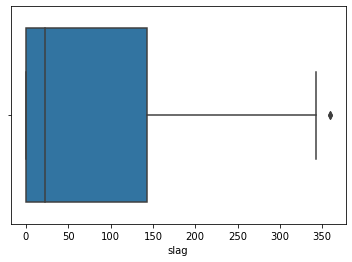

In [15]:
sns.boxplot(x="slag", data=df_main)

# Observation

There are 2 outlier values for slag

# ash

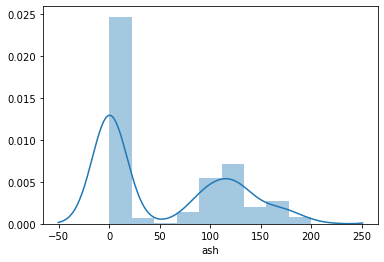

In [16]:
sns.distplot(df_main['ash'])

Ash is right skewed.

In [17]:
#calculate interquartile range of values in the 'ash' column
q75, q25 = np.percentile(df_main['ash'], [75 ,25])
iqr = q75 - q25

# Inter Quartile Range 
print('First Quartile is: ',q25)
print('Third Quartile is: ',q75)
print('Inter Quartile Range for ash is: ',iqr)

# Outlier detection
limit_lo = q25-1.5*iqr
limit_uo = q75+1.5*iqr

print('The lower limit for outliers in ash is: ',limit_lo)
print('The upper limit for outliers in ash is: ',limit_uo)

# Identifying outlier values in dataset
ash_uo = df_main[df_main['ash']>limit_uo]['ash'].count()
ash_lo = df_main[df_main['ash']<limit_lo]['ash'].count()

print('Number of upper outliers in the dataset for ash = ',ash_uo)
print('Number of lower outliers in the dataset for ash = ',ash_lo)

First Quartile is:  0.0
Third Quartile is:  118.3
Inter Quartile Range for ash is:  118.3
The lower limit for outliers in ash is:  -177.45
The upper limit for outliers in ash is:  295.75
Number of upper outliers in the dataset for ash =  0
Number of lower outliers in the dataset for ash =  0


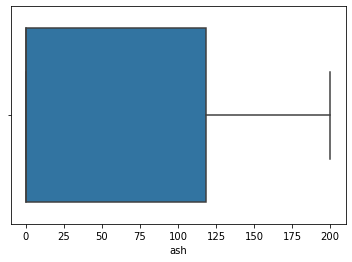

In [18]:
sns.boxplot(x="ash", data=df_main)

# Observation

There are no outlier values for ash

# water

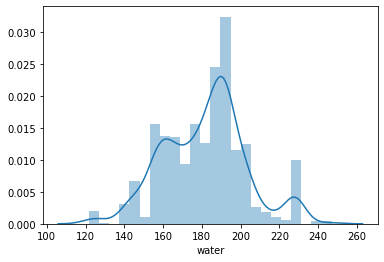

In [19]:
sns.distplot(df_main['water'])

Water is left skewed.

In [20]:
#calculate interquartile range of values in the 'water' column
q75, q25 = np.percentile(df_main['water'], [75 ,25])
iqr = q75 - q25

# Inter Quartile Range 
print('First Quartile is: ',q25)
print('Third Quartile is: ',q75)
print('Inter Quartile Range for water is: ',iqr)

# Outlier detection
limit_lo = q25-1.5*iqr
limit_uo = q75+1.5*iqr

print('The lower limit for outliers in water is: ',limit_lo)
print('The upper limit for outliers in water is: ',limit_uo)

# Identifying outlier values in dataset
wtr_uo = df_main[df_main['water']>limit_uo]['water'].count()
wtr_lo = df_main[df_main['water']<limit_lo]['water'].count()

print('Number of upper outliers in the dataset for water = ',wtr_uo)
print('Number of lower outliers in the dataset for water = ',wtr_lo)

First Quartile is:  164.9
Third Quartile is:  192.0
Inter Quartile Range for water is:  27.099999999999994
The lower limit for outliers in water is:  124.25000000000001
The upper limit for outliers in water is:  232.64999999999998
Number of upper outliers in the dataset for water =  4
Number of lower outliers in the dataset for water =  5


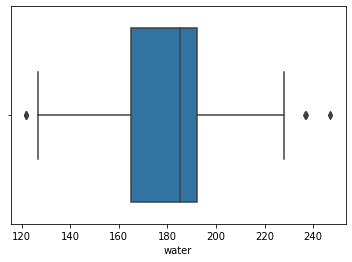

In [21]:
sns.boxplot(x="water", data=df_main)

# Observation

There are 9 outlier values for water - 4 upper and 5 lower

# superplastic

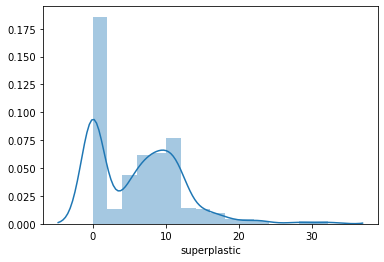

In [22]:
sns.distplot(df_main['superplastic'])

Superplastic is right skewed.

In [23]:
#calculate interquartile range of values in the 'superplastic' column
q75, q25 = np.percentile(df_main['superplastic'], [75 ,25])
iqr = q75 - q25

# Inter Quartile Range 
print('First Quartile is: ',q25)
print('Third Quartile is: ',q75)
print('Inter Quartile Range for superplastic is: ',iqr)

# Outlier detection
limit_lo = q25-1.5*iqr
limit_uo = q75+1.5*iqr

print('The lower limit for outliers in superplastic is: ',limit_lo)
print('The upper limit for outliers in superplastic is: ',limit_uo)

# Identifying outlier values in dataset
sp_uo = df_main[df_main['superplastic']>limit_uo]['superplastic'].count()
sp_lo = df_main[df_main['superplastic']<limit_lo]['superplastic'].count()

print('Number of upper outliers in the dataset for superplastic = ',sp_uo)
print('Number of lower outliers in the dataset for superplastic = ',sp_lo)

First Quartile is:  0.0
Third Quartile is:  10.2
Inter Quartile Range for superplastic is:  10.2
The lower limit for outliers in superplastic is:  -15.299999999999999
The upper limit for outliers in superplastic is:  25.5
Number of upper outliers in the dataset for superplastic =  10
Number of lower outliers in the dataset for superplastic =  0


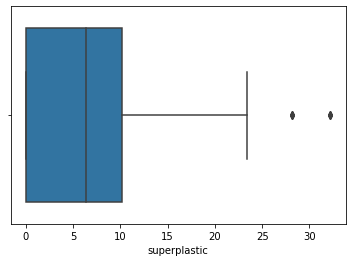

In [24]:
sns.boxplot(x="superplastic", data=df_main)

# Observation

There are 10 outlier values for superplastic

# coarseagg

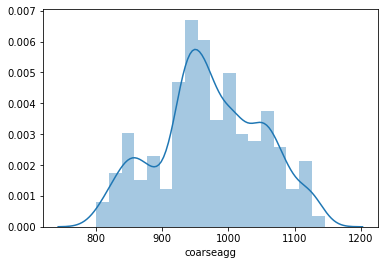

In [25]:
sns.distplot(df_main['coarseagg'])

Coarseagg has a near-normal distribution.

In [26]:
#calculate interquartile range of values in the 'coarseagg' column
q75, q25 = np.percentile(df_main['coarseagg'], [75 ,25])
iqr = q75 - q25

# Inter Quartile Range 
print('First Quartile is: ',q25)
print('Third Quartile is: ',q75)
print('Inter Quartile Range for coarseagg is: ',iqr)

# Outlier detection
limit_lo = q25-1.5*iqr
limit_uo = q75+1.5*iqr

print('The lower limit for outliers in coarseagg is: ',limit_lo)
print('The upper limit for outliers in coarseagg is: ',limit_uo)

# Identifying outlier values in dataset
cag_uo = df_main[df_main['coarseagg']>limit_uo]['coarseagg'].count()
cag_lo = df_main[df_main['coarseagg']<limit_lo]['coarseagg'].count()

print('Number of upper outliers in the dataset for coarseagg = ',cag_uo)
print('Number of lower outliers in the dataset for coarseagg = ',cag_lo)

First Quartile is:  932.0
Third Quartile is:  1029.4
Inter Quartile Range for coarseagg is:  97.40000000000009
The lower limit for outliers in coarseagg is:  785.8999999999999
The upper limit for outliers in coarseagg is:  1175.5000000000002
Number of upper outliers in the dataset for coarseagg =  0
Number of lower outliers in the dataset for coarseagg =  0


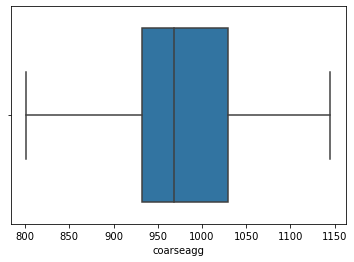

In [27]:
sns.boxplot(x="coarseagg", data=df_main)

# Observation

There are no outlier values for coarseagg

# fineagg

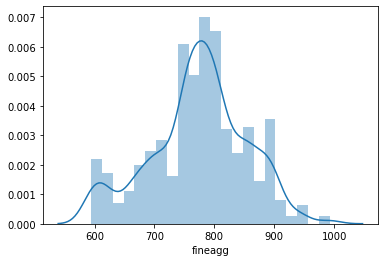

In [28]:
sns.distplot(df_main['fineagg'])

Fineagg has a near-normal distribution.

In [29]:
#calculate interquartile range of values in the 'fineagg' column
q75, q25 = np.percentile(df_main['fineagg'], [75 ,25])
iqr = q75 - q25

# Inter Quartile Range 
print('First Quartile is: ',q25)
print('Third Quartile is: ',q75)
print('Inter Quartile Range for fineagg is: ',iqr)

# Outlier detection
limit_lo = q25-1.5*iqr
limit_uo = q75+1.5*iqr

print('The lower limit for outliers in fineagg is: ',limit_lo)
print('The upper limit for outliers in fineagg is: ',limit_uo)

# Identifying outlier values in dataset
fin_uo = df_main[df_main['fineagg']>limit_uo]['fineagg'].count()
fin_lo = df_main[df_main['fineagg']<limit_lo]['fineagg'].count()

print('Number of upper outliers in the dataset for fineagg = ',fin_uo)
print('Number of lower outliers in the dataset for fineagg = ',fin_lo)

First Quartile is:  730.9499999999999
Third Quartile is:  824.0
Inter Quartile Range for fineagg is:  93.05000000000007
The lower limit for outliers in fineagg is:  591.3749999999998
The upper limit for outliers in fineagg is:  963.575
Number of upper outliers in the dataset for fineagg =  5
Number of lower outliers in the dataset for fineagg =  0


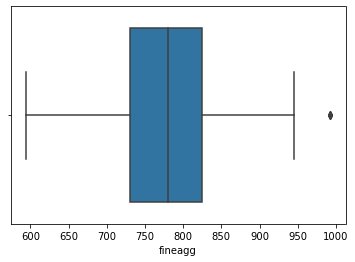

In [30]:
sns.boxplot(x="fineagg", data=df_main)

# Observation

There are 5 outlier values for fineagg

# age

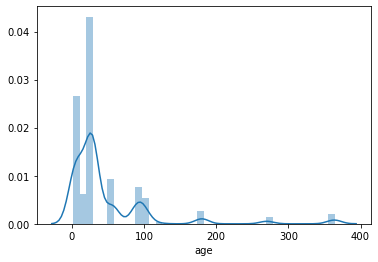

In [31]:
sns.distplot(df_main['age'])

Age is heavily skewed to the right.

In [32]:
#calculate interquartile range of values in the 'age' column
q75, q25 = np.percentile(df_main['age'], [75 ,25])
iqr = q75 - q25

# Inter Quartile Range 
print('First Quartile is: ',q25)
print('Third Quartile is: ',q75)
print('Inter Quartile Range for age is: ',iqr)

# Outlier detection
limit_lo = q25-1.5*iqr
limit_uo = q75+1.5*iqr

print('The lower limit for outliers in age is: ',limit_lo)
print('The upper limit for outliers in age is: ',limit_uo)

# Identifying outlier values in dataset
age_uo = df_main[df_main['age']>limit_uo]['age'].count()
age_lo = df_main[df_main['age']<limit_lo]['age'].count()

print('Number of upper outliers in the dataset for age = ',age_uo)
print('Number of lower outliers in the dataset for age = ',age_lo)

First Quartile is:  7.0
Third Quartile is:  56.0
Inter Quartile Range for age is:  49.0
The lower limit for outliers in age is:  -66.5
The upper limit for outliers in age is:  129.5
Number of upper outliers in the dataset for age =  59
Number of lower outliers in the dataset for age =  0


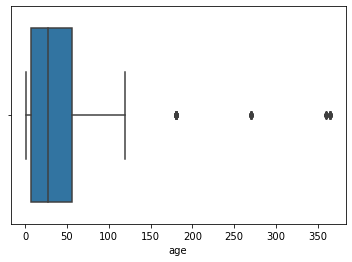

In [33]:
sns.boxplot(x="age", data=df_main)

# Observation

There are 59 outlier values above the upper limit for age

# Bivariate Analysis

# Correlation

Pairplot

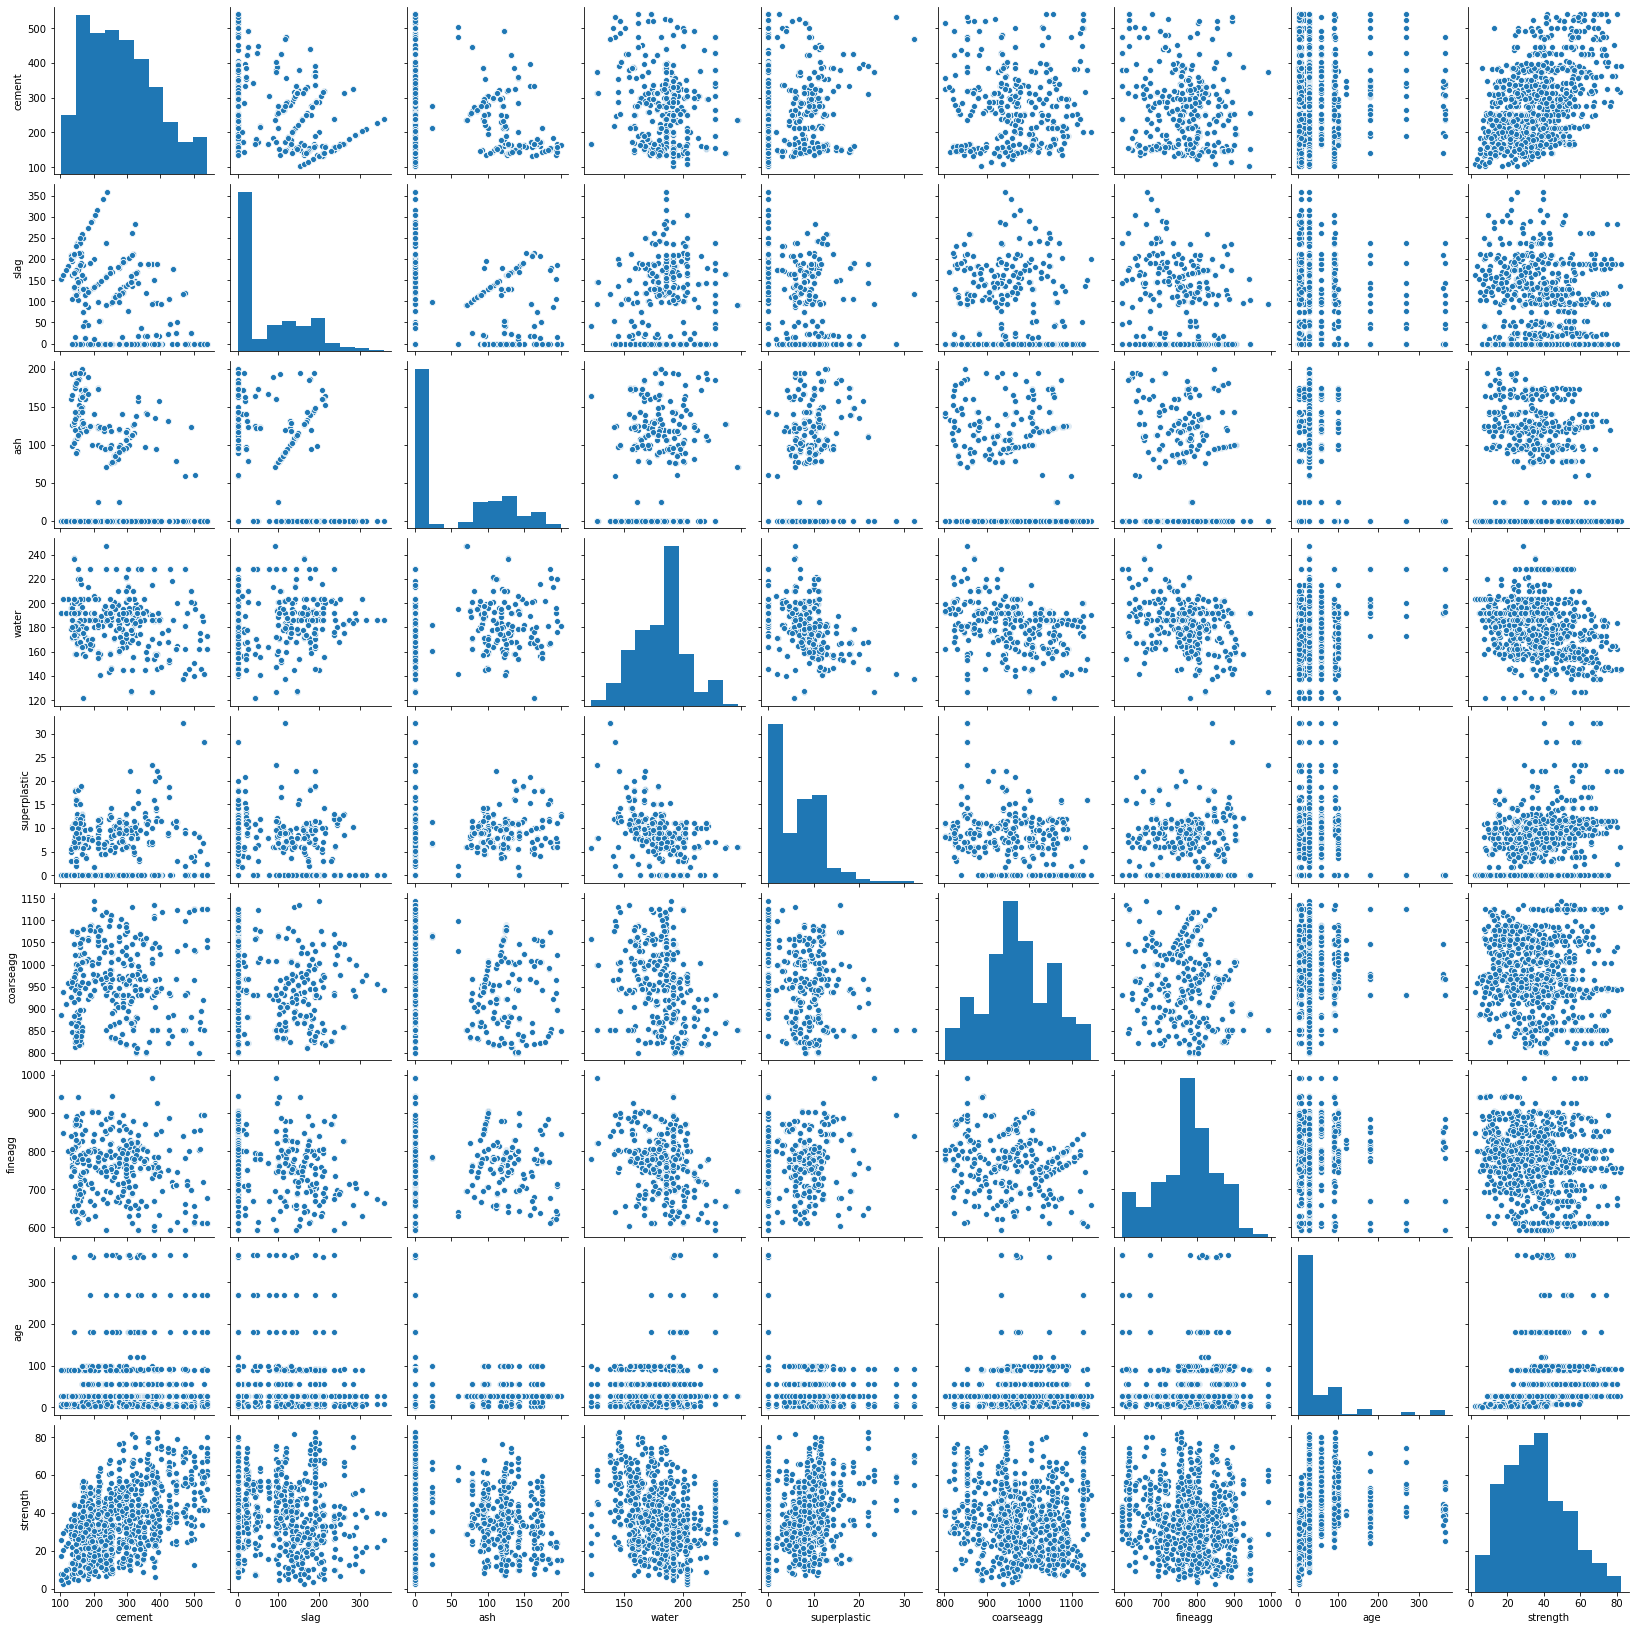

In [34]:
sns.pairplot(data = df_main)

Heatmap

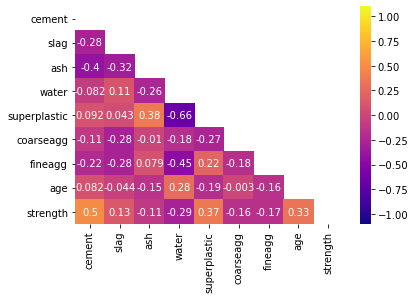

In [35]:
cor = df_main.corr()
matrix = np.triu(cor)
sns.heatmap(cor, annot=True, mask=matrix, vmin=-1.1,vmax=1.1, cmap='plasma')

Observation

There are no strongly correlated variables.

Correlation between target variable and other independent variables

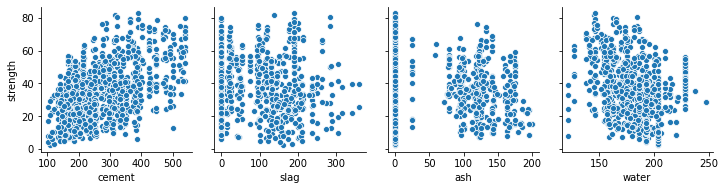

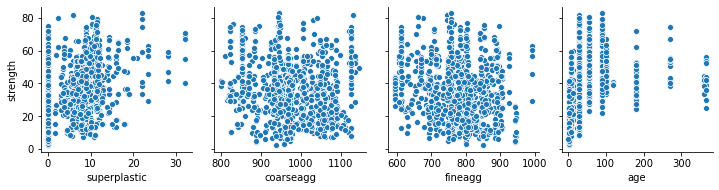

In [36]:
sns.pairplot(data = df_main, y_vars = ['strength'], x_vars = ['cement', 'slag', 'ash','water'])
sns.pairplot(data = df_main, y_vars = ['strength'], x_vars = [ 'superplastic','coarseagg', 'fineagg', 'age'])

Observation

    The correlation between cement and strength is positively linear
    There are no clear relationships between strength and other independent variables

Replacing outlier values for all columns other than strength(target variable) to the respective median values.

In [37]:
# Making a working copy of dataset to preserve original dataset
df_work = df_main.copy()

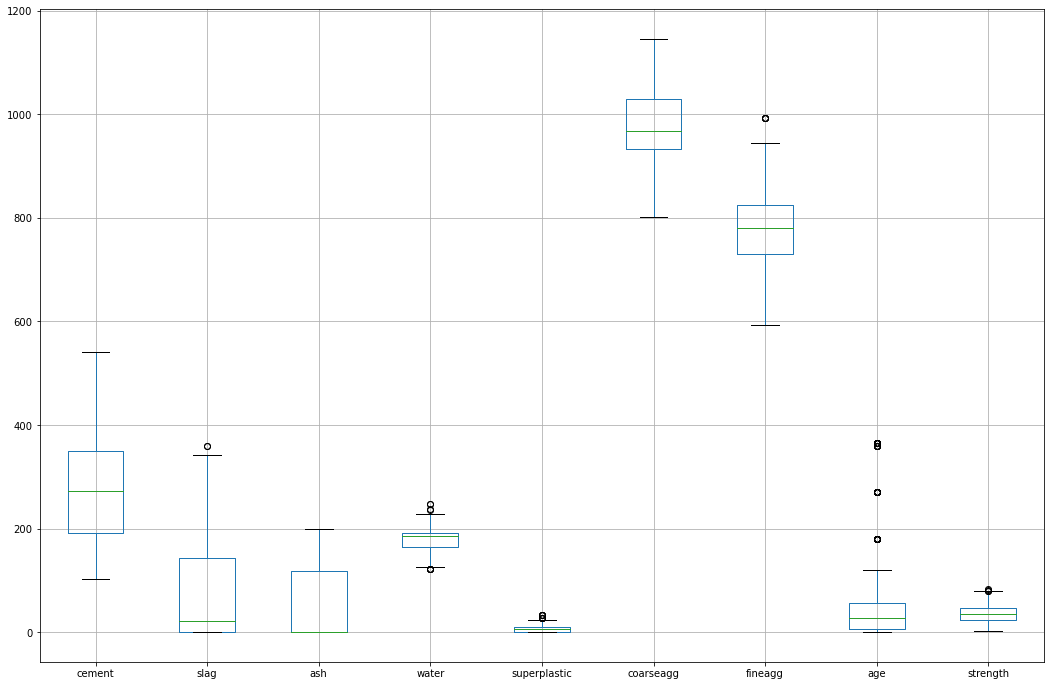

In [38]:
df_work.boxplot(figsize = (18,12))

In [39]:
print('-------------------------------------')
for colname in df_work.columns[:-1]:
    q75, q25 = np.percentile(df_main[df_work[colname].name], [75 ,25])
    iqr = q75 - q25
    print('IQR for ',df_work[colname].name,' is:', iqr)
    print('Median for ',df_work[colname].name,' is:', df_work[colname].median())


    limit_lo = q25-1.5*iqr
    limit_uo = q75+1.5*iqr
    print('Lower limit for IQR for',df_work[colname].name,' is: ',limit_lo)
    print('Upper limit for IQR for',df_work[colname].name,' is: ',limit_uo)
    
    print('Replacing outliers of',df_work[colname].name,' with median value')
    df_work.loc[(df_work[colname] < limit_lo) | (df_work[colname] > limit_uo), colname] = df_work[colname].median()
    print('-------------------------------------')

-------------------------------------
IQR for  cement  is: 157.625
Median for  cement  is: 272.9
Lower limit for IQR for cement  is:  -44.0625
Upper limit for IQR for cement  is:  586.4375
Replacing outliers of cement  with median value
-------------------------------------
IQR for  slag  is: 142.95
Median for  slag  is: 22.0
Lower limit for IQR for slag  is:  -214.42499999999998
Upper limit for IQR for slag  is:  357.375
Replacing outliers of slag  with median value
-------------------------------------
IQR for  ash  is: 118.3
Median for  ash  is: 0.0
Lower limit for IQR for ash  is:  -177.45
Upper limit for IQR for ash  is:  295.75
Replacing outliers of ash  with median value
-------------------------------------
IQR for  water  is: 27.099999999999994
Median for  water  is: 185.0
Lower limit for IQR for water  is:  124.25000000000001
Upper limit for IQR for water  is:  232.64999999999998
Replacing outliers of water  with median value
-------------------------------------
IQR for  sup

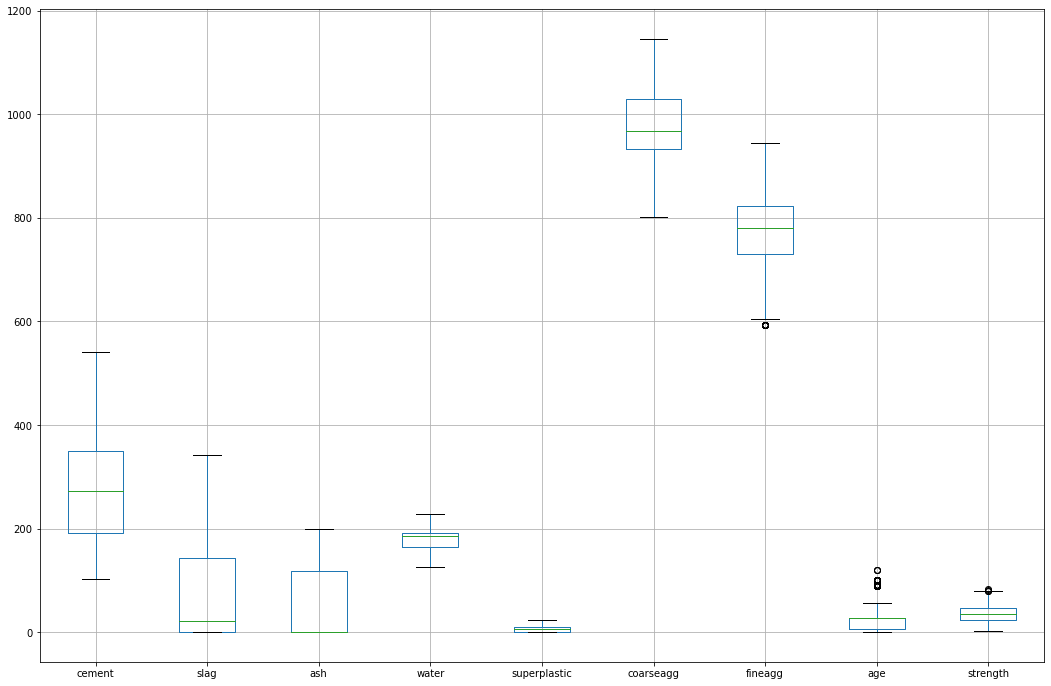

In [40]:
df_work.boxplot(figsize = (18,12))

In [41]:
df_main.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


In [42]:
df_work.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.240680,85.384419,0.00,0.000,22.000,142.725,342.1
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.653107,20.603205,126.60,164.900,185.000,192.000,228.0
superplastic,1030.0,5.973592,5.477165,0.00,0.000,6.400,10.075,23.4
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,772.546019,78.703232,594.00,730.950,779.400,822.200,945.0
age,1030.0,32.256311,27.803705,1.00,7.000,28.000,28.000,120.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


# Observation

The outliers for all columns other than strength have been replaced with the respective median values

This has reduced the number of outliers by a huge margin

    For example, after the replacement, the average value for age has come down from 45.66 to 32.25
    The standard deviation for age has come down from 63.17 to 27.80
    We can see that the minimum value for water has increased from 121.80 to 126.60
    Also, the max values for independent variables such as slag, water, superplastic, fineagg and age have changed 

# Feature Engineering

There is no possibility of dropping any features from the dataset since there are no highly correlated features
There are no new features to be derived from existing features since all independent features represent a unique characteristic of the concrete mixture

# Train-Test Split

Step 1: Split independent and dependent features into different datasets before scaling to avoid data leaks

In [43]:
X = df_work.drop('strength', axis = 1)
y = df_work['strength']

In [44]:
X.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28.0
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14.0
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28.0
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28.0
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28.0


In [45]:
y.head()

0    29.89
1    23.51
2    29.22
3    45.85
4    18.29
Name: strength, dtype: float64

Step 2: Use zscore to scale dependent variables

In [46]:
X_scaled = X.apply(zscore)
df_xscaled = pd.DataFrame(X_scaled,columns = df_work.columns)

In [47]:
df_xscaled.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,-1.339017,1.625902,-0.847144,1.060879,-1.091166,-0.014398,-0.305676,-0.153159,NaN
1,-1.074790,-0.363717,1.096078,-1.134020,0.881615,1.388141,0.300692,-0.656933,NaN
2,-0.298384,-0.858192,0.648965,0.279067,-0.086509,-0.206121,1.126981,-0.153159,NaN
3,-0.145209,0.477594,-0.847144,2.250592,-1.091166,-0.526517,-1.303578,-0.153159,NaN
4,-1.209776,1.290784,-0.847144,0.565570,0.571085,0.958372,-0.964165,-0.153159,NaN


# Placeholder for Complexity determination

Step 3: Split both independent and dependent variables into Train and Test datasets

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 1)

<IPython.core.display.Javascript object>

# Model Building

# Random Forest

In [49]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

<IPython.core.display.Javascript object>

RandomForestRegressor()

In [50]:
y_pred = rf_model.predict(X_test)

In [51]:
print('Performance on training data: ',rf_model.score(X_train, y_train))

Performance on training data:  0.9800899336317977


In [52]:
print('Performance on testing data: ',rf_model.score(X_test, y_test))

Performance on testing data:  0.9048775304914507


The test score has dropped significantly from training score. This means there is overfitting in the model.

R2 Score - coefficient of determination

In [53]:
acc_rf = metrics.r2_score(y_test, y_pred)
print('The accuracy of random forest model is: ', acc_rf)

The accuracy of random forest model is:  0.9048775304914507


Mean Squared Error

In [54]:
mse_rf = metrics.mean_squared_error(y_test, y_pred)
print('The MSE for random forest model is: ', mse_rf)

The MSE for random forest model is:  27.68440157727819


The R2 score needs to be improved and MSE should be reduced.

Build dataframe to compare metrics across models

In [55]:
model_compare_rf = pd.DataFrame({'ModelType':['RF'], 'Accuracy':acc_rf}, index={1})
model_compare_final = model_compare_rf
model_compare_final

,ModelType,Accuracy
1,RF,0.904878


# KFold CV on RF

In [56]:
kfold = KFold(n_splits = 20, random_state = 70)
K_out = cross_val_score(rf_model, X, y, cv = kfold)
K_out

/Users/muraliharidass/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


array([0.86870474, 0.8775757 , 0.86192103, 0.88201817, 0.94884288,
       0.94752538, 0.90195729, 0.91594639, 0.92093557, 0.8578545 ,
       0.94439702, 0.92931166, 0.90030515, 0.9238174 , 0.90316003,
       0.9026168 , 0.92682235, 0.94415567, 0.93636228, 0.93853259])

In [57]:
acc_kfcvrf = np.mean(abs(K_out))
print('The accuracy of KFold cross validation on random forest model is: ', acc_kfcvrf)

The accuracy of KFold cross validation on random forest model is:  0.9116381309984707


In [58]:
model_compare_kfcvrf = pd.DataFrame({'ModelType':['KFold CV RF'], 'Accuracy':acc_kfcvrf}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_kfcvrf])
model_compare_final

,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638


# Gradient Boosting

In [59]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

<IPython.core.display.Javascript object>

GradientBoostingRegressor()

In [60]:
y_pred = gb_model.predict(X_test)

In [61]:
print('Performance on training data: ',gb_model.score(X_train, y_train))

Performance on training data:  0.9430469892492805


In [62]:
print('Performance on testing data: ',gb_model.score(X_test, y_test))

Performance on testing data:  0.8921413203426055


The test score has dropped significantly from training score.

In [63]:
acc_gb = metrics.r2_score(y_test, y_pred)
print('The accuracy of gradient boosting model is: ', acc_gb)

The accuracy of gradient boosting model is:  0.8921413203426055


In [64]:
mse_gb = metrics.mean_squared_error(y_test, y_pred)
print('The MSE for gradient boosting model is: ', mse_gb)

The MSE for gradient boosting model is:  31.391142562398887


In [65]:
model_compare_gb = pd.DataFrame({'ModelType':['GB'], 'Accuracy':acc_gb}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_gb])
model_compare_final

,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141


# KFold CV on GB

In [66]:
kfold = KFold(n_splits = 20, random_state = 70)
K_out = cross_val_score(gb_model, X, y, cv = kfold)
K_out

/Users/muraliharidass/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


array([0.88380543, 0.8955591 , 0.87662742, 0.88698034, 0.93924752,
       0.90424604, 0.86726238, 0.91602011, 0.9167013 , 0.82874159,
       0.91780429, 0.91785797, 0.92740941, 0.90506246, 0.92343111,
       0.86167351, 0.92657187, 0.91160414, 0.8944975 , 0.89400424])

In [67]:
acc_kfcvgb = np.mean(abs(K_out))
print('The accuracy of KFold cross validation on graident boosting model is: ', acc_kfcvgb)

The accuracy of KFold cross validation on graident boosting model is:  0.8997553854530098


In [68]:
model_compare_kfcvgb = pd.DataFrame({'ModelType':['KFold CV GB'], 'Accuracy':acc_kfcvgb}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_kfcvgb])
model_compare_final

,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755


# Bagging Regressor

In [69]:
bgr_model = BaggingRegressor()
bgr_model.fit(X_train, y_train)

BaggingRegressor()

In [70]:
y_pred = bgr_model.predict(X_test)

In [71]:
print('Performance on training data: ',bgr_model.score(X_train, y_train))

Performance on training data:  0.9700296815856438


In [72]:
print('Performance on testing data: ',bgr_model.score(X_test, y_test))

Performance on testing data:  0.8812862431940465


In [73]:
acc_bgr = metrics.r2_score(y_test, y_pred)
print('The accuracy of bagging model is: ', acc_bgr)

The accuracy of bagging model is:  0.8812862431940465


In [74]:
mse_bgr = metrics.mean_squared_error(y_test, y_pred)
print('The MSE for bagging model is: ', mse_bgr)

The MSE for bagging model is:  34.55039942868573


In [75]:
model_compare_bgr = pd.DataFrame({'ModelType':['BGR'], 'Accuracy':acc_bgr}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_bgr])
model_compare_final

,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286


# KFold CV on Bagging

In [76]:
kfold = KFold(n_splits = 20, random_state = 70)
K_out = cross_val_score(bgr_model, X, y, cv = kfold)
K_out

/Users/muraliharidass/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


array([0.85558286, 0.8698957 , 0.8513685 , 0.8816165 , 0.94379413,
       0.9572431 , 0.91191498, 0.90623527, 0.91333107, 0.8700399 ,
       0.94661208, 0.93254479, 0.90720182, 0.9148125 , 0.88780305,
       0.89598526, 0.89754349, 0.9365545 , 0.92021921, 0.91999634])

In [77]:
acc_kfcvbgr = np.mean(abs(K_out))
print('The accuracy of KFold cross validation on bagging regressor model is: ', acc_kfcvbgr)

The accuracy of KFold cross validation on bagging regressor model is:  0.9060147526471883


In [78]:
model_compare_kfcvbgr = pd.DataFrame({'ModelType':['KFold CV BGR'], 'Accuracy':acc_kfcvbgr}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_kfcvbgr])
model_compare_final

,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286
1,KFold CV BGR,0.906015


# Decision Tree

In [79]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [80]:
y_pred = dt_model.predict(X_test)

In [81]:
print('Performance on training data: ',dt_model.score(X_train, y_train))

Performance on training data:  0.9917907420889983


In [82]:
print('Performance on testing data: ',dt_model.score(X_test, y_test))

Performance on testing data:  0.8591152340371372


In [83]:
acc_dt = metrics.r2_score(y_test, y_pred)
print('The accuracy of decision tree model is: ', acc_dt)

The accuracy of decision tree model is:  0.8591152340371372


In [84]:
mse_dt = metrics.mean_squared_error(y_test, y_pred)
print('The MSE for decision tree model is: ', mse_dt)

The MSE for decision tree model is:  41.00304015641856


In [85]:
model_compare_dt = pd.DataFrame({'ModelType':['DT'], 'Accuracy':acc_dt}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_dt])
model_compare_final

,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286
1,KFold CV BGR,0.906015
1,DT,0.859115


# KFold CV on Decision Tree

In [86]:
kfold = KFold(n_splits = 20, random_state = 70)
K_out = cross_val_score(dt_model, X, y, cv = kfold)
K_out

/Users/muraliharidass/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


array([0.82586737, 0.85173865, 0.81383349, 0.86511727, 0.95806417,
       0.92735817, 0.8392711 , 0.86568419, 0.85030819, 0.81895716,
       0.92998716, 0.91425543, 0.85308258, 0.90464226, 0.83898553,
       0.88456521, 0.85710012, 0.87712112, 0.83975683, 0.92101005])

In [87]:
acc_kfcvdt = np.mean(abs(K_out))
print('The accuracy of KFold cross validation on decision tree model is: ', acc_kfcvdt)

The accuracy of KFold cross validation on decision tree model is:  0.8718353026108547


In [88]:
model_compare_kfcvdt = pd.DataFrame({'ModelType':['KFold CV DT'], 'Accuracy':acc_kfcvdt}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_kfcvdt])
model_compare_final

,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286
1,KFold CV BGR,0.906015
1,DT,0.859115
1,KFold CV DT,0.871835


# Feature Importance
Verify Feature Importance to check which features have considerable impact on the dependent variable - 'strength'

In [89]:
df_work.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28.0,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14.0,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28.0,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28.0,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28.0,18.29


In [90]:
FImp = pd.DataFrame(dt_model.feature_importances_,columns=['Importance'], index=X_train.columns)
print('Feature Importance: ')
FImp

Feature Importance: 


,Importance
cement,0.352576
slag,0.095446
ash,0.014303
water,0.127373
superplastic,0.015745
coarseagg,0.035222
fineagg,0.030811
age,0.328524


Observations

    The contributions of 'ash' and 'superplastic' in determining the strength of concrete are very minimal - 0.01
    'coarseagg' and 'fineagg' have a negligible impact on the strength as well ~ 0.03
    The amount of 'cement' and 'age' of curing seem to be the major factors influencing the strength of concrete
    'water' has a significant influence too

Drop features that do not have a significant impact on target variable
and split independent and dependent features as individual datasets.

In [91]:
df_final = df_main.copy()

In [92]:
X = df_final.drop(['strength', 'ash', 'coarseagg', 'fineagg'], axis=1)
y = df_final['strength']

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

<IPython.core.display.Javascript object>

Scale Independent variables

In [94]:
X_train = X_train.apply(zscore)
X_test = X_test.apply(zscore)

In [95]:
X_train.head()

,cement,slag,water,superplastic,age
185,0.664379,-0.853882,1.018949,-1.063738,-0.498924
286,0.892753,1.338789,-0.522038,0.652806,0.702810
600,-0.030256,-0.853882,0.456887,-1.063738,-0.670601
691,0.949846,0.247089,2.189912,-1.063738,-0.608173
474,0.721473,-0.853882,0.550564,0.805765,-0.280427


In [96]:
X_test.head()

,cement,slag,water,superplastic,age
339,-0.461266,0.959132,0.454319,-0.985509,0.739811
244,1.064182,-0.863937,0.454319,-0.985509,0.739811
882,-0.679881,-0.863937,-1.300665,0.911573,-0.508212
567,-1.248281,1.261041,0.501244,0.473785,-0.278313
923,0.257735,-0.863937,0.454319,-0.985509,-0.623161


In [97]:
dtlean_model = DecisionTreeRegressor()
dtlean_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [98]:
y_pred = dtlean_model.predict(X_test)

In [99]:
print('Performance on training data: ',dtlean_model.score(X_train, y_train))

Performance on training data:  0.9944457747205377


In [100]:
print('Performance on testing data: ',dtlean_model.score(X_test, y_test))

Performance on testing data:  0.7537811109318635


In [101]:
acc_dtlean = metrics.r2_score(y_test, y_pred)
print('The accuracy of DT model after dropping features is: ', acc_dtlean)

The accuracy of DT model after dropping features is:  0.7537811109318635


In [102]:
mse_dtlean = metrics.mean_squared_error(y_test, y_pred)
print('The MSE for DT model after dropping features is: ', mse_dtlean)

The MSE for DT model after dropping features is:  71.65943689320389


In [103]:
model_compare_dtlean = pd.DataFrame({'ModelType':['DT Lean'], 'Accuracy':acc_dtlean}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_dtlean])
model_compare_final

,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286
1,KFold CV BGR,0.906015
1,DT,0.859115
1,KFold CV DT,0.871835
1,DT Lean,0.753781


In [104]:
FImp_lean = pd.DataFrame(dtlean_model.feature_importances_,columns=['Importance'], index=X_train.columns)
print('Feature Importance: ')
FImp_lean

Feature Importance: 


,Importance
cement,0.381502
slag,0.115939
water,0.133899
superplastic,0.031619
age,0.337041


# Hyperparameter Tuning

In [105]:
X = df_work.drop(['strength'], axis=1)
y = df_work['strength']

In [106]:
Xscaled = X.apply(zscore)
df_Xscaled = pd.DataFrame(Xscaled, columns = df_work.columns)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, test_size = 0.3, random_state = 1)

<IPython.core.display.Javascript object>

Pruning Decision Tree - 1

In [108]:
dtprun1_model = DecisionTreeRegressor(max_depth = 4, random_state = 1, min_samples_leaf = 5)
dtprun1_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, random_state=1)

In [109]:
y_pred = dtprun1_model.predict(X_test)

In [110]:
print('Performance on training data: ',dtprun1_model.score(X_train, y_train))

Performance on training data:  0.7255811799299219


In [111]:
print('Performance on testing data: ',dtprun1_model.score(X_test, y_test))

Performance on testing data:  0.654827718610513


In [112]:
acc_dtprun1 = metrics.r2_score(y_test, y_pred)
print('The accuracy of pruned DT model 1 is: ', acc_dtprun1)

The accuracy of pruned DT model 1 is:  0.654827718610513


In [113]:
mse_dtprun1 = metrics.mean_squared_error(y_test, y_pred)
print('The MSE for pruned DT model 1 is: ', mse_dtprun1)

The MSE for pruned DT model 1 is:  100.45878855650365


In [114]:
model_compare_dtprun1 = pd.DataFrame({'ModelType':['DT Prune 1'], 'Accuracy':acc_dtprun1}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_dtprun1])
model_compare_final

,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286
1,KFold CV BGR,0.906015
1,DT,0.859115
1,KFold CV DT,0.871835
1,DT Lean,0.753781
1,DT Prune 1,0.654828


Pruning Decision Tree - 2

In [115]:
dtprun2_model = DecisionTreeRegressor(max_depth = 3, random_state = 1, min_samples_leaf = 5)
dtprun2_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, min_samples_leaf=5, random_state=1)

In [116]:
y_pred = dtprun2_model.predict(X_test)

In [117]:
print('Performance on training data: ',dtprun2_model.score(X_train, y_train))

Performance on training data:  0.6358072763408258


In [118]:
print('Performance on testing data: ',dtprun2_model.score(X_test, y_test))

Performance on testing data:  0.583104124329016


In [119]:
acc_dtprun2 = metrics.r2_score(y_test, y_pred)
print('The accuracy of pruned DT model 2 is: ', acc_dtprun2)

The accuracy of pruned DT model 2 is:  0.583104124329016


In [120]:
mse_dtprun2 = metrics.mean_squared_error(y_test, y_pred)
print('The MSE for pruned DT model 2 is: ', mse_dtprun2)

The MSE for pruned DT model 2 is:  121.33319180647683


In [121]:
model_compare_dtprun2 = pd.DataFrame({'ModelType':['DT Prune 2'], 'Accuracy':acc_dtprun2}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_dtprun2])
model_compare_final

,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286
1,KFold CV BGR,0.906015
1,DT,0.859115
1,KFold CV DT,0.871835
1,DT Lean,0.753781
1,DT Prune 1,0.654828


Pruning Decision Tree - 3

In [122]:
dtprun3_model = DecisionTreeRegressor(max_depth = 7, random_state = 1, min_samples_leaf = 5)
dtprun3_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=7, min_samples_leaf=5, random_state=1)

In [123]:
y_pred = dtprun3_model.predict(X_test)

In [124]:
print('Performance on training data: ',dtprun3_model.score(X_train, y_train))

Performance on training data:  0.8810978202241866


In [125]:
print('Performance on testing data: ',dtprun3_model.score(X_test, y_test))

Performance on testing data:  0.7667130313733328


In [126]:
acc_dtprun3 = metrics.r2_score(y_test, y_pred)
print('The accuracy of pruned DT model 3 is: ', acc_dtprun3)

The accuracy of pruned DT model 3 is:  0.7667130313733328


In [127]:
mse_dtprun3 = metrics.mean_squared_error(y_test, y_pred)
print('The MSE for pruned DT model 3 is: ', mse_dtprun3)

The MSE for pruned DT model 3 is:  67.895736470825


In [128]:
model_compare_dtprun3 = pd.DataFrame({'ModelType':['DT Prune 3'], 'Accuracy':acc_dtprun3}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_dtprun3])
model_compare_final

,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286
1,KFold CV BGR,0.906015
1,DT,0.859115
1,KFold CV DT,0.871835
1,DT Lean,0.753781
1,DT Prune 1,0.654828


Pruning Decision Tree - 4

In [129]:
dtprun4_model = DecisionTreeRegressor(max_depth = 10, random_state = 1, min_samples_leaf = 5)
dtprun4_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, random_state=1)

In [130]:
y_pred = dtprun4_model.predict(X_test)

In [131]:
print('Performance on training data: ',dtprun4_model.score(X_train, y_train))

Performance on training data:  0.9125624824655981


In [132]:
print('Performance on testing data: ',dtprun4_model.score(X_test, y_test))

Performance on testing data:  0.8092956351000694


In [133]:
acc_dtprun4 = metrics.r2_score(y_test, y_pred)
print('The accuracy of pruned DT model 4 is: ', acc_dtprun4)

The accuracy of pruned DT model 4 is:  0.8092956351000694


In [134]:
mse_dtprun4 = metrics.mean_squared_error(y_test, y_pred)
print('The MSE for pruned DT model 4 is: ', mse_dtprun4)

The MSE for pruned DT model 4 is:  55.50251426089147


In [135]:
model_compare_dtprun4 = pd.DataFrame({'ModelType':['DT Prune 4'], 'Accuracy':acc_dtprun4}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_dtprun4])
model_compare_final

,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286
1,KFold CV BGR,0.906015
1,DT,0.859115
1,KFold CV DT,0.871835
1,DT Lean,0.753781
1,DT Prune 1,0.654828


Pruning Decision Tree - 5

In [136]:
dtprun5_model = DecisionTreeRegressor(max_depth = 20, random_state = 1, min_samples_leaf = 5)
dtprun5_model.fit(X_train, y_train)

y_pred = dtprun5_model.predict(X_test)

print('Performance on training data: ',dtprun5_model.score(X_train, y_train))

print('Performance on testing data: ',dtprun5_model.score(X_test, y_test))

acc_dtprun5 = metrics.r2_score(y_test, y_pred)
print('The accuracy of pruned DT model 5 is: ', acc_dtprun5)

mse_dtprun5 = metrics.mean_squared_error(y_test, y_pred)
print('The MSE for pruned DT model 5 is: ', mse_dtprun5)

model_compare_dtprun5 = pd.DataFrame({'ModelType':['DT Prune 5'], 'Accuracy':acc_dtprun5}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_dtprun5])
model_compare_final

Performance on training data:  0.9181220612133028
Performance on testing data:  0.8147211421584408
The accuracy of pruned DT model 5 is:  0.8147211421584408
The MSE for pruned DT model 5 is:  53.92347707924206


,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286
1,KFold CV BGR,0.906015
1,DT,0.859115
1,KFold CV DT,0.871835
1,DT Lean,0.753781
1,DT Prune 1,0.654828


Pruning Decision Tree - 6

In [137]:
dtprun6_model = DecisionTreeRegressor(max_depth = 15, random_state = 1, min_samples_leaf = 3)
dtprun6_model.fit(X_train, y_train)

y_pred = dtprun6_model.predict(X_test)

print('Performance on training data: ',dtprun6_model.score(X_train, y_train))

print('Performance on testing data: ',dtprun6_model.score(X_test, y_test))

acc_dtprun6 = metrics.r2_score(y_test, y_pred)
print('The accuracy of pruned DT model 6 is: ', acc_dtprun6)

mse_dtprun6 = metrics.mean_squared_error(y_test, y_pred)
print('The MSE for pruned DT model 6 is: ', mse_dtprun6)

model_compare_dtprun6 = pd.DataFrame({'ModelType':['DT Prune 6'], 'Accuracy':acc_dtprun6}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_dtprun6])
model_compare_final

Performance on training data:  0.9519845857245934
Performance on testing data:  0.8385167190871566
The accuracy of pruned DT model 6 is:  0.8385167190871566
The MSE for pruned DT model 6 is:  46.998022863628194


,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286
1,KFold CV BGR,0.906015
1,DT,0.859115
1,KFold CV DT,0.871835
1,DT Lean,0.753781
1,DT Prune 1,0.654828


Pruning Decision Tree - 7

In [138]:
dtprun7_model = DecisionTreeRegressor(max_depth = 20, random_state = 1, min_samples_leaf = 3)
dtprun7_model.fit(X_train, y_train)

y_pred = dtprun7_model.predict(X_test)

print('Performance on training data: ',dtprun7_model.score(X_train, y_train))

print('Performance on testing data: ',dtprun7_model.score(X_test, y_test))

acc_dtprun7 = metrics.r2_score(y_test, y_pred)
print('The accuracy of pruned DT model 7 is: ', acc_dtprun7)

mse_dtprun7 = metrics.mean_squared_error(y_test, y_pred)
print('The MSE for pruned DT model 7 is: ', mse_dtprun7)

model_compare_dtprun7 = pd.DataFrame({'ModelType':['DT Prune 7'], 'Accuracy':acc_dtprun7}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_dtprun7])
model_compare_final

Performance on training data:  0.9524865839560286
Performance on testing data:  0.839781974304168
The accuracy of pruned DT model 7 is:  0.839781974304168
The MSE for pruned DT model 7 is:  46.629783543239846


,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286
1,KFold CV BGR,0.906015
1,DT,0.859115
1,KFold CV DT,0.871835
1,DT Lean,0.753781
1,DT Prune 1,0.654828


In [139]:
kfold = KFold(n_splits = 20, random_state = 70)
K_out = cross_val_score(dtprun7_model, X, y, cv = kfold)
K_out

acc_kfdtprun7 = np.mean(abs(K_out))
print('The accuracy of KFold cross validation on decision tree model is: ', acc_kfdtprun7)

model_compare_kfdtprun7 = pd.DataFrame({'ModelType':['KFold CV DT Prune 7'], 'Accuracy':acc_kfdtprun7}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_kfdtprun7])
model_compare_final

The accuracy of KFold cross validation on decision tree model is:  0.8558809091444661


/Users/muraliharidass/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286
1,KFold CV BGR,0.906015
1,DT,0.859115
1,KFold CV DT,0.871835
1,DT Lean,0.753781
1,DT Prune 1,0.654828


Pruning Decision Tree - 8

In [140]:
dtprun8_model = DecisionTreeRegressor(max_depth = 4, random_state = 1, min_samples_leaf = 5)
dtprun8_model.fit(X_train, y_train)

y_pred = dtprun8_model.predict(X_test)

print('Performance on training data: ',dtprun8_model.score(X_train, y_train))

print('Performance on testing data: ',dtprun8_model.score(X_test, y_test))

acc_dtprun8 = metrics.r2_score(y_test, y_pred)
print('The accuracy of pruned DT model 8 is: ', acc_dtprun8)

mse_dtprun8 = metrics.mean_squared_error(y_test, y_pred)
print('The MSE for pruned DT model 8 is: ', mse_dtprun8)

model_compare_dtprun8 = pd.DataFrame({'ModelType':['DT Prune 8'], 'Accuracy':acc_dtprun8}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_dtprun8])
model_compare_final



Performance on training data:  0.7255811799299219
Performance on testing data:  0.654827718610513
The accuracy of pruned DT model 8 is:  0.654827718610513
The MSE for pruned DT model 8 is:  100.45878855650365


,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286
1,KFold CV BGR,0.906015
1,DT,0.859115
1,KFold CV DT,0.871835
1,DT Lean,0.753781
1,DT Prune 1,0.654828


KFold on DT Prune 8

In [141]:
kfold = KFold(n_splits = 20, random_state = 70)
K_out = cross_val_score(dtprun8_model, X, y, cv = kfold)
K_out

acc_kfdtprun8 = np.mean(abs(K_out))
print('The accuracy of KFold cross validation on decision tree model is: ', acc_kfdtprun8)

model_compare_kfdtprun8 = pd.DataFrame({'ModelType':['KFold CV DT Prune 8'], 'Accuracy':acc_kfdtprun8}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_kfdtprun8])
model_compare_final

/Users/muraliharidass/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


The accuracy of KFold cross validation on decision tree model is:  0.6785562583989005


,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286
1,KFold CV BGR,0.906015
1,DT,0.859115
1,KFold CV DT,0.871835
1,DT Lean,0.753781
1,DT Prune 1,0.654828


# Observations

From the above set of results, we can conclude that:

    Random Forest algorithm performs the best with a score of 0.899
    On performing a KFold cross validation on the random forest, we achieve a score of 0.911
    Gradient Boost has a score of 0.891 and performing KFold CV on Gradient Boost helped achieve 0.899
    Bagging scored 0.898 and a KFold CV on this pushed it to 0.903
    Decision Tree achieved a score of 0.847 and a KFold CV on the DT achieved 0.875

After this, we performed feature engineering to identify and remove the features with negligible influence on the target variable - strength. Based on feature importance study, we removed 'ash', 'coarseagg', 'fineagg' and 'superplastic'

    Decision Tree algorithm on this lean dataset scored 0.750
    We performed hyper parameter tuning on this model and recorded the various scores.
    The best score of 0.839 was achieved using max_depth = 20, random_state = 1, min_samples_leaf = 3
    A KFold CV on this tree achieved 0.855
    
From the above result set we can conclude that Random Forest and Gradient Boosting are the best models with 0.899 and 0.898 score values. We will perform Grid search on these two models to improve their performance.
    

# Grid Search on Random Forest

In [142]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 70, 80, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Instantiate the grid search model
gs_rf = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv = 5)

gs_rf.fit(X_train, y_train)

print(" Best cross-validation accuracy: {:.2f}". format( gs_rf.best_score_)) 
print(" Best parameters: ", gs_rf.best_params_) 
# print(" Test set accuracy: {:.2f}". format( gs_rf.score( X_test, y_test)))


acc_gs_rf = gs_rf.score( X_test, y_test)
print('The accuracy of Grid search on Random Forest model is: ', acc_gs_rf)

model_compare_gs_rf = pd.DataFrame({'ModelType':['GS RF'], 'Accuracy':acc_gs_rf}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_gs_rf])
model_compare_final



 Best cross-validation accuracy: 0.86
 Best parameters:  {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
The accuracy of Grid search on Random Forest model is:  0.8743303756720469


,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286
1,KFold CV BGR,0.906015
1,DT,0.859115
1,KFold CV DT,0.871835
1,DT Lean,0.753781
1,DT Prune 1,0.654828


# Grid Search on Gradient Boosting

In [143]:
param_grid = {'learning_rate': [0.01,0.02,0.03,0.04],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [10,20,50, 100],
              'max_depth'    : [4,6,8,10]
             }

gs_gb = GridSearchCV(estimator=gb_model, param_grid = param_grid, cv = 2)

gs_gb.fit(X_train, y_train)

print(" Best cross-validation accuracy: {:.2f}". format( gs_gb.best_score_)) 
print(" Best parameters: ", gs_gb.best_params_) 
# print(" Test set accuracy: {:.2f}". format( gs_gb.score( X_test, y_test)))


acc_gs_gb = gs_gb.score(X_test, y_test)
print('The accuracy of Grid search on Gradient Boosting model is: ', acc_gs_gb)

model_compare_gs_gb = pd.DataFrame({'ModelType':['GS GB'], 'Accuracy':acc_gs_gb}, index={1})
model_compare_final = pd.concat([model_compare_final, model_compare_gs_gb])
model_compare_final


 Best cross-validation accuracy: 0.90
 Best parameters:  {'learning_rate': 0.04, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.5}
The accuracy of Grid search on Gradient Boosting model is:  0.9111123714828236


,ModelType,Accuracy
1,RF,0.904878
1,KFold CV RF,0.911638
1,GB,0.892141
1,KFold CV GB,0.899755
1,BGR,0.881286
1,KFold CV BGR,0.906015
1,DT,0.859115
1,KFold CV DT,0.871835
1,DT Lean,0.753781
1,DT Prune 1,0.654828


In [144]:
gs_gb.predict(X_test)

array([42.3192687 , 44.07300371, 34.24587416, 25.49558785, 16.05962604,
       24.02387332, 43.52023813, 63.60214456, 22.56708979, 30.59592952,
       35.75816276, 13.57581699, 46.25256832, 19.01999965, 48.32779349,
       37.86233394, 35.14180119, 22.73719863, 23.8732269 , 32.87034991,
       24.93935647, 34.25298071, 16.28456154, 45.28578523, 30.73583034,
       61.62243811, 41.07315168, 34.45584075, 36.69631246, 34.52733003,
       13.73531035, 42.58573125, 38.21499666, 48.64512223, 28.23378894,
       45.94386763, 13.26582248, 15.24492763, 20.87619772, 48.67529401,
       15.16991712, 29.33808395, 70.37870772, 76.51471461, 32.71543345,
       42.39212357, 26.15048411, 16.52590841, 31.77187981, 45.7851893 ,
       59.48349239, 34.86716674, 12.80867789, 15.50976551, 19.1007715 ,
       39.78715598,  6.7673151 , 32.93319915, 13.99138204, 48.20773438,
       38.22234232, 49.34242101, 30.03582116, 76.05572242, 63.75355917,
       48.49821913, 22.66563098, 12.65429433, 22.51957465, 21.58

In [145]:
y_test.head()

339    47.78
244    48.79
882    33.70
567    18.28
923    14.99
Name: strength, dtype: float64

# Observations

    As evident from the above comparison between various models, applying Grid Search on Gradient Boosting helped achieve a score of 0.91
    This algorithm predicts the results with an accuracy of 91%
    The score indicates that the algorithm predicts the correct strength using the given set of independent variables accurately 91% of the times
    Using grid search, we were able to increase the score of the algorithm from 89% to 91%
    
# Recommendations

    The features that affect the strength of concrete are: cement, slag, water, superplastic and age
    The other components such as ash, coarseagg and fineagg do not have significant influence on the strength of the concrete mixture

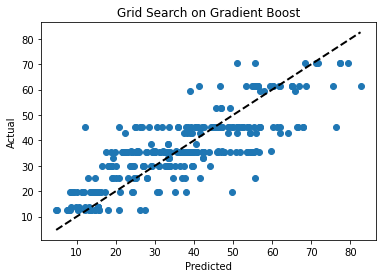

In [149]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Grid Search on Gradient Boost")
plt.show()